# General fit example (2)

(model testing)

Author: Aleksander Filip Żarnecki (University of Warsaw)

### (0) Import libraries 

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.stats import f

### (1) Definition of model

Consider controlled parameter range is [0,1]

In [2]:
# True functional dependece polinomial background + two peaks

def mytrue(x):
    
    bg = 10.0 - 2* x + x*x
    
    sig1 = 20.0 * norm.pdf(x, loc=0.44, scale=0.05)
    
    sig2 = 5.0 * norm.pdf(x, loc=0.55, scale=0.10)

    return bg + sig1 +sig2


# Basic fit function, return function values only
#
#  Parameters: 0 - 2 background
#              3 - 5 first peak
#              6 - 8 second peak
#
def myfun(x,par):

    npar = par.size   # should be 6 for sigle peak or 9 for double peak fit
    
    bg = par[0] + par[1]*x + par[2]*x*x
    
    if npar<6 :
        return bg
    
    sig1 = par[3] * norm.pdf(x, loc=par[4], scale=par[5])
    
    if npar<9 :
        return bg + sig1
    
    sig2 = par[6] * norm.pdf(x, loc=par[7], scale=par[8])

    return bg + sig1 + sig2

# Full model: returns values and derivatives

def myfunder(x,par):

    npar = par.size   # should be 6 for sigle peak or 9 for double peak fit

    # output arrays
    
    val = np.zeros(x.size)
    der = np.zeros((x.size,npar))

    # Background
    
    bg = par[0] + par[1]*x + par[2]*x*x
    
    der[:,0] = 1
    der[:,1] = x
    der[:,2] = x*x
   
    val += bg
    
    if npar < 6 :
        return val,der
    
    # First signal peak
    
    sig1 = norm.pdf(x, loc=par[4], scale=par[5])
    
    der[:,3] = sig1
    sig1 *= par[3]
    der[:,4] = (x-par[4])/par[5]/par[5]*sig1
    der[:,5] = (x-par[4])*(x-par[4])/par[5]/par[5]/par[5]*sig1
    
    val += sig1
    
    if npar < 9 :
        return val,der
    
    # Second signal peak
    
    sig2 = norm.pdf(x, loc=par[7], scale=par[8])
    
    der[:,6] = sig2
    sig2 *= par[6]
    der[:,7] = (x-par[7])/par[8]/par[8]*sig2
    der[:,8] = (x-par[7])*(x-par[7])/par[8]/par[8]/par[8]*sig2
    
    val += sig2
       
    return val,der



### (2) Generate pseudo data to fit

In [3]:
# Considered values of x

xvec = np.linspace(0.025,0.975,20)

# Measurement precision

svec = np.linspace(2.,4.,xvec.size)
# svec = np.linspace(0.2,0.3,xvec.size)   # Uncomment to test the impact of uncertainties
s2vec = svec*svec

# Pseudo-data

yvec = np.random.normal(mytrue(xvec),svec)


### (3) Initial fit settings

In [4]:
# Number of function parameters to consider 

Nfun1 = 9

# Second hypothesis to compare (Nfun2<Nfun1 !!!)

Nfun2 = 6

# Initial guess for parameters (Nfun1)

parini = np.zeros(Nfun1)

# Background guess

parini[0] = 10.
parini[1] = -1.
parini[2] = +1.

# First peak guess

parini[3] = 20.
parini[4] = 0.4
parini[5] = 0.1

# Second peak guess

parini[6] = 5.
parini[7] = 0.5
parini[8] = 0.1

### (4) Iterative fit procedure

In [5]:
# Helper function for chi2 calculation
# Uses global data vectors: xvec,yvec,s2vec

def mychi2(parvec):
    fvec = myfun(xvec,parvec) 
    chi2 = np.sum((yvec-fvec)**2/s2vec)
    return chi2

In [6]:
# Main fit procedure
# Uses global data vectors: xvec,yvec,s2vec

def myiterfit(parini):
    
    Nfun = parini.size
    
    lam = 0.01   
    dcut = 0.0001 

    chi2min = mychi2(parini)
    parmin = parini

    par = parini

    Nit = 0
    Nimp = 0

    Cov = np.zeros((Nfun,Nfun))

    dist = dcut+1

    while dist > dcut :

        # work space

        A = np.zeros((Nfun,Nfun))
        B = np.zeros(Nfun)

        # Values and derivatives at the current point

        fval,fder = myfunder(xvec,par)

        dyvec = yvec-fval

        for l in range(Nfun):
            B[l] = np.sum(fder[:,l]*dyvec/s2vec)
            for k in range(Nfun):
                A[l,k] = np.sum(fder[:,l]*fder[:,k]/s2vec)

        # Do not try to jump directly to the maximum (lam = 0)

        C = A
        for l in range(Nfun):
            C[l,l] *= 1 + lam

        # Inverse of matrix

        Cinv = np.linalg.inv(C)

        # Solution to the problem - required parameter change

        dpar = Cinv @ B

        # Check new parameter values

        parnew = par+dpar

        chi2new = mychi2(parnew)

        # Estimate the distance to minimum from current step (in units of current errors)

        Cov = np.linalg.inv(A)
        e2par = np.diagonal(Cov)
        dist = np.sum(dpar*dpar/e2par)

        Nit+=1

        if chi2new < chi2min :
            Nimp += 1
            lam /= 10
            chi2min = chi2new
            par = parnew
        else:
            lam *= 10


    # Parameter uncertainties 
    # (assuming no need to recalculate Cov, even if there was a slight improvement in the last step)

    epar = np.sqrt(np.diagonal(Cov))

    print("\n Fit results:\n\n     par         sigma_p\n")

    for ip in range(par.size):
        print("  %8.3f  +/- %6.3f " % (par[ip],epar[ip]))

    # Calculate correlation matrix, including rounding

    Corr = Cov

    print("\n Correlation matrix\n")
    for ip in range(par.size):
        for jp in range(par.size):
            Corr[ip,jp]=int(1000.*Corr[ip,jp]/epar[ip]/epar[jp]+0.5)/1000.

        print(Corr[ip,:])

    # Fitted function

    fvec = myfun(xvec,par) 

    # Chi^2 printout

    chi2 = np.sum((yvec-fvec)**2/s2vec)

    print("\n chi^2 =  %8.3f   chi^2/Ndf = %8.5f " % (chi2,chi2/(xvec.size-Nfun)))

    return chi2,par,epar

### (5) Actual fit

In [7]:
# For first hypothesis

chi2_1,par_1,epar_1 = myiterfit(parini)

# For function plotting

x_fun = np.linspace(0.,1.,101)
fun_1 = myfun(x_fun,par_1) 

bg_1 = myfun(x_fun,par_1[:3])
f1_1 = myfun(x_fun,par_1[:6])


 Fit results:

     par         sigma_p

    10.243  +/-  1.299 
     4.025  +/-  7.882 
    -3.319  +/-  8.434 
    24.665  +/-  0.400 
     0.439  +/-  0.002 
     0.060  +/-  0.002 
    -1.998  +/-  1.508 
     0.354  +/-  0.004 
     0.018  +/-  0.008 

 Correlation matrix

[ 1.    -0.679  0.527  0.065  0.039  0.027  0.    -0.01   0.002]
[-0.679  1.    -0.958 -0.3    0.139 -0.332  0.039 -0.026 -0.04 ]
[ 0.527 -0.958  1.     0.299 -0.155  0.328 -0.037  0.033  0.04 ]
[ 0.065 -0.3    0.299  1.    -0.055 -0.115  0.032  0.145  0.045]
[ 0.039  0.139 -0.155 -0.055  1.    -0.732  0.158 -0.098 -0.245]
[ 0.027 -0.332  0.328 -0.115 -0.732  1.    -0.171  0.021  0.222]
[ 0.     0.039 -0.037  0.032  0.158 -0.171  1.     0.881  0.894]
[-0.01  -0.026  0.033  0.145 -0.098  0.021  0.881  1.     0.882]
[ 0.002 -0.04   0.04   0.045 -0.245  0.222  0.894  0.882  1.   ]

 chi^2 =    28.330   chi^2/Ndf =  2.57542 


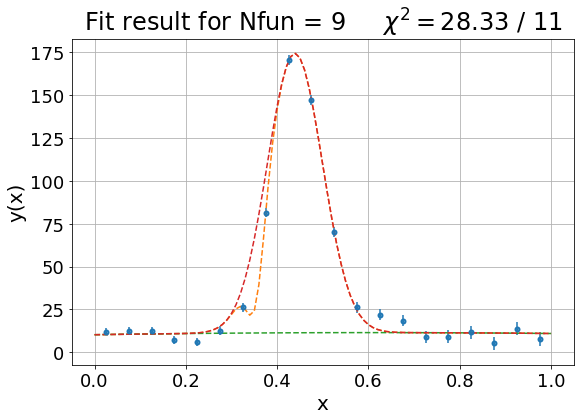

In [8]:
plt.figure(figsize=(9, 6))

plt.errorbar(xvec,yvec,svec, linestyle='none', marker='o', ms=2, mew=4)

plt.plot(x_fun,fun_1,'--')
plt.plot(x_fun,bg_1,'--')
plt.plot(x_fun,f1_1,'--')

plt.title('Fit result for Nfun = '+str(Nfun1) +'     $\chi^{2} = $'+str(int(100*chi2_1+0.5)/100.)+' / '+str(xvec.size-Nfun1),size=24)
plt.xlabel('x',size=20)
plt.ylabel('y(x)',size=20)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(which='major', axis='both')

fname = '09_fit3_'+str(Nfun1)+'.png'
plt.savefig(fname)

In [9]:
# For second hypothesis

chi2_2,par_2,epar_2 = myiterfit(parini[:6])

# For function plotting

fun_2 = myfun(x_fun,par_2) 

bg_2 = myfun(x_fun,par_2[:3])


 Fit results:

     par         sigma_p

     9.620  +/-  1.614 
    12.697  +/- 11.033 
   -12.254  +/- 11.660 
    22.169  +/-  0.379 
     0.444  +/-  0.001 
     0.054  +/-  0.001 

 Correlation matrix

[ 1.    -0.817  0.728  0.205  0.076  0.233]
[-0.817  1.    -0.977 -0.362 -0.045 -0.465]
[ 0.728 -0.977  1.     0.359  0.022  0.462]
[ 0.205 -0.362  0.359  1.     0.015 -0.212]
[ 0.076 -0.045  0.022  0.015  1.     0.082]
[ 0.233 -0.465  0.462 -0.212  0.082  1.   ]

 chi^2 =    38.113   chi^2/Ndf =  2.72233 


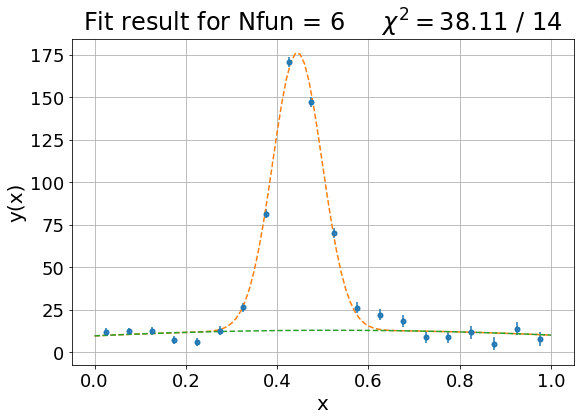

In [10]:
plt.figure(figsize=(9, 6))

plt.errorbar(xvec,yvec,svec, linestyle='none', marker='o', ms=2, mew=4)

plt.plot(x_fun,fun_2,'--')
plt.plot(x_fun,bg_2,'--')

plt.title('Fit result for Nfun = '+str(Nfun2) +'     $\chi^{2} = $'+str(int(100*chi2_2+0.5)/100.)+' / '+str(xvec.size-Nfun2),size=24)
plt.xlabel('x',size=20)
plt.ylabel('y(x)',size=20)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(which='major', axis='both')

fname = '09_fit3_'+str(Nfun2)+'.png'
plt.savefig(fname)

### (6) Test the two hypotheiss

In [11]:
# Fit with all parameters

Nchi_1 = xvec.size-Nfun1 
chi2ndf_1 = chi2_1/Nchi_1

# Change when removing parameters

Nchi_2 = Nfun1-Nfun2
chi2ndf_2 = (chi2_2-chi2_1)/Nchi_2

# Test value

Ftest = chi2ndf_2/chi2ndf_1

ptest = 1 - f.cdf(Ftest,Nchi_1,Nchi_2)

In [12]:
print("F-test result  p = %.4g " % (ptest))
print("probability of Chi2 increase by %6.3f when removing %d needless parameters" % (chi2_2-chi2_1,Nchi_2))

F-test result  p = 0.4755 
probability of Chi2 increase by  9.783 when removing 3 needless parameters
